<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# [Polytropic TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Initial Data

## Authors: Phil Chang & Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module sets up initial data for a [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) star in *spherical, isotropic coordinates*

**Module Status:** <font color='green'><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [start-to-finish TOV module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb) for full test). Note that convergence at the surface of the star is lower order due to the sharp drop to zero in $T^{\mu\nu}$.

### NRPy+ Source Code for this module: [TOV/TOV_Solver.py](../edit/TOV/TOV_Solver.py)

[comment]: <> (Introduction: TODO)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows:

1. [Step 1](#initializenrpy): **Initialize core Python/NRPy+ modules**
1. [Step 2](#polytropic_eoss): **Polytropic EOSs**
    1. [Step 2.a](#polytropic_eoss__continuity_of_pcold): *Continuity of $P_{\rm cold}$*
    1. [Step 2.b](#polytropic_eoss__continuity_of_epscold): *Continuity of $\epsilon_{\rm cold}$*
    1. [Step 2.c](#polytropic_eoss__parameters_from_input): *Setting up EOS parameters from user input*
    1. [Step 2.d](#polytropic_eoss__simple_test): *Simple test of our functions*
    1. [Step 2.e](#polytropic_eoss__pcold): *Computing $P_{\rm cold}\left(\rho_{b}\right)$*
    1. [Step 2.f](#polytropic_eoss__pcold_plot): *Visualizing $P_{\rm cold}\left(\rho_{b}\right)$*
1. [Step 3](#tov): **The TOV Equations**
1. [Step 4](#code_validation): **Code Validation against `TOV.TOV_Solver` NRPy+ module**
1. [Step 5](#latex_pdf_output): **Output this module to $\LaTeX$-formatted PDF**


<a id='initializenrpy'></a>

# Step 1: Initialize core Python/NRPy+ modules \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

In [1]:
# Step 1: Import needed Python/NRPy+ modules
import numpy as np
import scipy.integrate as si
import math
import sys

<a id='polytropic_eoss'></a>

# Step 2: Polytropic EOSs \[Back to [top](#toc)\]
$$\label{polytropic_eoss}$$

<a id='polytropic_eoss__continuity_of_pcold'></a>

## Step 2.a: Continuity of $P_{\rm cold}$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__continuity_of_pcold}$$

Consider a piecewise polytrope EOS of the form

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho_{b}^{\Gamma_{0}} & , & \rho_{b} \leq \rho_{0}\\
K_{1}\rho_{b}^{\Gamma_{1}} & , & \rho_{0} \leq \rho_{b} \leq \rho_{1}\\
\vdots &  & \vdots\\
K_{j}\rho_{b}^{\Gamma_{j}} & , & \rho_{j-1} \leq \rho_{b} \leq \rho_{j}\\
\vdots &  & \vdots\\
K_{N-2}\rho_{b}^{\Gamma_{N-2}} & , & \rho_{N-3} \leq \rho_{b} \leq \rho_{N-2}\\
K_{N-1}\rho_{b}^{\Gamma_{N-1}} & , & \rho_{b} \geq \rho_{N-2}
\end{matrix}
\right.
}\ .
$$

The case of a single polytrope is given by the first EOS above, with no condition imposed on the value of $\rho$, i.e.

$$
\boxed{P_{\rm cold} = K_{0}\rho_{b}^{\Gamma_{0}} = K\rho_{b}^{\Gamma}}\ .
$$

Notice that we have the following sets of variables:

$$
\left\{\underbrace{\rho_{0},\rho_{1},\ldots,\rho_{N-2}}_{N-1\ {\rm values}}\right\}\ ;\
\left\{\underbrace{K_{0},K_{1},\ldots,K_{N-1}}_{N\ {\rm values}}\right\}\ ;\
\left\{\underbrace{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N-1}}_{N\ {\rm values}}\right\}\ .
$$

Also, notice that $K_{0}$ and the entire sets $\left\{\rho_{0},\rho_{1},\ldots,\rho_{N-1}\right\}$ and $\left\{\Gamma_{0},\Gamma_{1},\ldots,\Gamma_{N}\right\}$ must be specified by the user. The values of $\left\{K_{1},\ldots,K_{N}\right\}$, on the other hand, are determined by imposing that $P_{\rm cold}$ be continuous, i.e.

$$
P_{\rm cold}\left(\rho_{0}\right) = K_{0}\rho_{0}^{\Gamma_{0}} = K_{1}\rho_{0}^{\Gamma_{1}} \implies
\boxed{K_{1} = K_{0}\rho_{0}^{\Gamma_{0}-\Gamma_{1}}}\ .
$$

Analogously,

$$
\boxed{K_{j} = K_{j-1}\rho_{j-1}^{\Gamma_{j-1}-\Gamma_{j}}\ ,\ j\in\left[1,N-1\right]}\ .
$$

Again, for the case of a single polytropic EOS, the set $\left\{\rho_{j}\right\}$ is empty and $\left\{\Gamma_{j},K_{j}\right\}\to \left\{\Gamma,K\right\}$.

Below we implement a function to set up $\left\{K_{j}\right\}$ for both single and piecewise polytropic EOSs, based on the last boxed equation above.

In [2]:
# Function     : impose_continuity_on_P_cold()
# Author(s)    : Leo Werneck
# Description  : This function populates the array K_poly_tab
#                by demanding that P_cold be everywhere continuous
# Dependencies : none
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - uninitialized, see output variable below
#                  P_poly_tab     - uninitialized, see function
#                                   compute_P_poly_tab() below
#                K_poly_tab0      - value of K_poly_tab[0], for the first EOS
#
# Outputs      : eos.K_poly_tab   - values of K to be used within each EOS, determined
#                                   by imposing that P_cold be everywhere continuous

def impose_continuity_on_P_cold(eos,K_poly_tab0):
    
    # A piecewise polytropic EOS is given by
    # .--------------------------------------------------------------------------.
    # |      /     K_0 * rho^(Gamma_0)     ,                rho < rho_0 ;        |
    # |      |     K_1 * rho^(Gamma_1)     ,        rho_0 < rho < rho_1 ;        |
    # |      |          ...                                 ...                  |
    # | P = <      K_j * rho^(Gamma_j)     ,    rho_(j-1) < rho < rho_j ;        |
    # |      |          ...                                 ...                  |
    # |      | K_(n-2) * rho^(Gamma_(n-2)) , rho_(neos-3) < rho < rho_(neos-2) ; |
    # |      \ K_(n-1) * rho^(Gamma_(n-1)) ,                rho > rho_(neos-2) . |
    # .--------------------------------------------------------------------------.
    # Notice that the case of a single polytropic EOS corresponds to
    # the first EOS in the boxed equation above, with no condition on
    # rho. Thus we need only return K_poly_tab0.
    eos.K_poly_tab[0] = K_poly_tab0
    if eos.neos==1:
        return
    
    # For the case of a piecewise polytropic EOS, emanding that P_cold
    # be everywhere continuous results in the relation:
    # .-----------------------------------------------------.
    # | K_j = K_(j-1) * rho_(j-1)^( Gamma_(j-1) - Gamma_j ) |
    # .-----------------------------------------------------.
    for j in range(1,eos.neos):
        eos.K_poly_tab[j] = eos.K_poly_tab[j-1]*eos.rho_poly_tab[j-1]**(eos.Gamma_poly_tab[j-1]-eos.Gamma_poly_tab[j])
        
    return

<a id='polytropic_eoss__p_poly_tab'></a>

## Step 2.b: Computing $P_{j}$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__p_poly_tab}$$

We now set a new set of quantities, $P_{\rm tab}$, which are used in a similar fashion to $\rho_{j}$, that is, to determine which EOS we should use. This quantity is defined as:

$$
\boxed{
P_{\rm tab} =
\left\{
\begin{matrix}
P_{0} = K_{0}\rho_{0}^{\Gamma_{0}}& , & P \leq P_{0} \implies \rho_{b} \leq \rho_{0}\\
P_{1} = K_{1}\rho_{1}^{\Gamma_{1}}& , & P_{0}\leq P\leq P_{1} \implies \rho_{0} \leq \rho_{b} \leq \rho_{1}\\
\vdots\\
P_{j} = K_{j}\rho_{j}^{\Gamma_{j}}& , & P_{j-1}\leq P\leq P_{j} \implies \rho_{j-1} \leq \rho_{b} \leq \rho_{j}\\
\vdots\\
P_{N-2} = K_{N-2}\rho_{N-2}^{\Gamma_{N-2}}& , & P_{N-3}\leq P\leq P_{N-2} \implies \rho_{N-3} \leq \rho_{b} \leq \rho_{N-2}\\
- & , & P \geq P_{N-2} \implies \rho_{b} \geq \rho_{N-2}\ .
\end{matrix}
\right.
}
$$

In [3]:
# Function     : compute_P_poly_tab()
# Author(s)    : Leo Werneck
# Description  : This function populates the array eos.P_poly_tab,
#                used to distinguish which EOS we are using in the
#                case of a piecewise polytropic EOS
# Dependencies : none
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - uninitialized, see output variable below
#
# Outputs      : eos.P_poly_tab   - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)

def compute_P_poly_tab(eos):
    
    # We now compute the values of P_poly_tab that are used
    # to find the appropriate polytropic index and, thus,
    # EOS we must use.
    # First, if we have a single polytrope EOS, we need to
    # do nothing.
    if eos.neos==1:
        return
    
    # For the case of a piecewise polytropic EOS, we have
    # .---------------------------.
    # | P_j = K_j*rho_j^(Gamma_j) |
    # .---------------------------.
    for j in range(eos.neos-1):
        eos.P_poly_tab[j] = eos.K_poly_tab[j]*rho_poly_tab[j]**(Gamma_poly_tab[j])
        
    return

<a id='polytropic_eoss__parameters_from_input'></a>

## Step 2.c: Setting up EOS parameters from user input \[Back to [top](#toc)\]
$$\label{polytropic_eoss__parameters_from_input}$$

We now implement a driver function to set up all polytropic EOS related quantities based on the input given by the user. From the given input set:

$$
\left\{n_{\rm eos}, \rho_{j}, \Gamma_{j}, K_{0}\right\}\ ,
$$

the code returns a "C like struct" (a [*named tuple*](https://docs.python.org/3/library/collections.html#collections.namedtuple)) containing

$$
\left\{n_{\rm eos}, \rho_{j}, \Gamma_{j}, K_{j}, P_{j}\right\}\ .
$$

In [4]:
# Function     : set_single_or_piecewise_polytrope_EOS_parameters()
# Author(s)    : Leo Werneck
# Description  : This function determine all polytropic related
#                parameters from user input
# Dependencies : impose_continuity_on_P_cold()
#                compute_P_poly_tab()
#
# Inputs       : neos             - number of EOSs to be used (single polytrope = 1)
#                rho_poly_tab     - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                Gamma_poly_tab   - values of Gamma to be used within each EOS
#                K_poly_tab0      - value of K_poly_tab[0], for the first EOS
#
# Outputs      : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)

def set_single_or_piecewise_polytrope_EOS_parameters(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0):

    # Error check #1: Verify if the correct number of rho_poly_tab has been given by the user
    if (neos == 1):
        pass
    elif len(rho_poly_tab) != neos-1:
        print("Error: neos="+str(neos)+". Expected "+str(neos-1)+" values of rho_poly_tab, but "+str(len(rho_poly_tab))+" values were given.")
        sys.exit(1)

    # Error check #2: Verify if the correct number of Gamma_poly_tab has been given by the user
    if len(Gamma_poly_tab) != neos:
        print("Error: neos="+str(neos)+". Expected "+str(neos)+" values of Gamma_poly_tab, but "+str(len(Gamma_poly_tab))+" values were given.")
        sys.exit(2)

    # Create the arrays to store the values of K_poly_tab and eps_integ_const_tab
    K_poly_tab = [0 for i in range(neos)]
    P_poly_tab = [0 for i in range(neos-1)]
    
    # Create the EOS "struct" (named tuple)
    from collections import namedtuple
    eos_struct = namedtuple("eos_struct","neos rho_poly_tab Gamma_poly_tab K_poly_tab P_poly_tab")
    eos = eos_struct(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab,P_poly_tab)

    # Step 1: Determine K_poly_tab. For the details, please see the implementation
    #         of the function impose_continuity_on_P_cold() below.
    impose_continuity_on_P_cold(eos,K_poly_tab0)
    
    # Step 2: Determine eps_integ_const_tab. For the details, please see the
    #         implementation of the function impose_continuity_on_eps_cold() below.
    compute_P_poly_tab(eos)
    
    return eos

<a id='polytropic_eoss__pcold'></a>

## Step 2.d: Computing $P_{\rm cold}\left(\rho_{b}\right)$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__pcold}$$

Then, let us compute $P_{\rm cold}$ for a polytropic EOS:

$$
\boxed{
P_{\rm cold} =
\left\{
\begin{matrix}
K_{0}\rho_{b}^{\Gamma_{0}} & , & \rho_{b} \leq \rho_{0}\\
K_{1}\rho_{b}^{\Gamma_{1}} & , & \rho_{0} \leq \rho_{b} \leq \rho_{1}\\
\vdots &  & \vdots\\
K_{j}\rho_{b}^{\Gamma_{j}} & , & \rho_{j-1} \leq \rho_{b} \leq \rho_{j}\\
\vdots &  & \vdots\\
K_{N-2}\rho_{b}^{\Gamma_{N-2}} & , & \rho_{N-3} \leq \rho_{b} \leq \rho_{N-2}\\
K_{N-1}\rho_{b}^{\Gamma_{N-1}} & , & \rho_{b} \geq \rho_{N-2}
\end{matrix}
\right.
}\ .
$$

In [5]:
# Function     : Polytrope_EOS__compute_P_cold_from_rhob()
# Author(s)    : Leo Werneck
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                rho_baryon       - the value of rho for which we want to
#                                   compute P_cold
#
# Outputs      : P_cold           - for a single or piecewise polytropic EOS

def Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_baryon):
    
    # Compute the polytropic index from rho_baryon
    j = polytropic_index_from_rhob(eos, rho_baryon)
    
    # Return the value of P_cold for a polytropic EOS
    # .--------------------------------.
    # | P_cold = K_j * rho_b^(Gamma_j) |
    # .--------------------------------.
    return eos.K_poly_tab[j]*rho_baryon**eos.Gamma_poly_tab[j]

<a id='polytropic_eoss__rhob'></a>

## Step 2.e: Computing $\rho_{b}\left(P_{\rm cold}\right)$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__rhob}$$

Then, let us compute $\rho_{b}$ as a function of $P_{\rm cold}\equiv P$ for a polytropic EOS:

$$
\boxed{
\rho_{b} =
\left\{
\begin{matrix}
\left(\frac{P}{K_{0}}\right)^{1/\Gamma_{0}} & , & P \leq P_{0}\\
\left(\frac{P}{K_{1}}\right)^{1/\Gamma_{1}} & , & P_{0} \leq P \leq P_{1}\\
\vdots &  & \vdots\\
\left(\frac{P}{K_{j}}\right)^{1/\Gamma_{j}} & , & P_{j-1} \leq P \leq P_{j}\\
\vdots &  & \vdots\\
\left(\frac{P}{K_{N-2}}\right)^{1/\Gamma_{N-2}} & , & P_{N-3} \leq P \leq P_{N-2}\\
\left(\frac{P}{K_{N-1}}\right)^{1/\Gamma_{N-1}} & , & P \geq P_{N-2}
\end{matrix}
\right.
}\ .
$$

In [6]:
# Function     : Polytrope_EOS__compute_P_cold_from_rhob()
# Author(s)    : Leo Werneck
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Inputs       : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                P                - the value of P for which we want to
#                                   compute rho_b
#
# Outputs      : rho_baryon       - for a single or piecewise polytropic EOS

def Polytrope_EOS__compute_rhob_from_P_cold(eos,P):
    
    # Compute the polytropic index from P
    j = polytropic_index_from_P(eos,P)
    
    # Return the value of rho_b for a polytropic EOS
    # .----------------------------------.
    # | rho_b = (P_cold/K_j)^(1/Gamma_j) |
    # .----------------------------------.
    return (P/eos.K_poly_tab[j])**(1.0/eos.Gamma_poly_tab[j])

<a id='polytropic_eoss__polytropic_index'></a>

## Step 2.f: Determining the polytropic index \[Back to [top](#toc)\]
$$\label{polytropic_eoss__polytropic_index}$$

<a id='polytropic_eoss__polytropic_index__from_rhob'></a>

## Step 2.f.i: From $\rho_{b}$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__polytropic_index__from_rhob}$$

The function below determines the polytropic index from a given value $\rho_{b} = \rho_{\rm in}$.

In [7]:
# Function     : polytropic_index_from_rhob()
# Author(s)    : Leo Werneck and Zach Etienne
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Input(s)     : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                rho_in           - value of rho for which we compute the
#                                   polytropic index
#
# Output(s)    : polytropic index computed from rho_in

def polytropic_index_from_rhob(eos, rho_in):
    
    # Returns the value of the polytropic index based on rho_in
    polytropic_index = 0
    if not (eos.neos==1):
        for j in range(eos.neos-1):
            polytropic_index += (rho_in > eos.rho_poly_tab[j])
            
    return polytropic_index

<a id='polytropic_eoss__polytropic_index__from_p'></a>

## Step 2.f.ii: From $P$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__polytropic_index__from_p}$$

The function below determines the polytropic index from a given value $P_{\rm cold} = P$.

In [8]:
# Function     : polytropic_index_from_P()
# Author(s)    : Leo Werneck and Zach Etienne
# Description  : This function computes P_cold for a polytropic EOS
# Dependencies : none
#
# Input(s)     : eos              - named tuple containing the following:
#                  neos           - number of EOSs to be used (single polytrope = 1)
#                  rho_poly_tab   - values of rho distinguish one EOS from the
#                                   other (not required for a single polytrope)
#                  Gamma_poly_tab - values of Gamma to be used within each EOS
#                  K_poly_tab     - value of K to be used within each EOS
#                  P_poly_tab     - values of P used to distinguish one EOS from
#                                   the other (not required for a single polytrope)
#                P_in             - value of P for which we compute the
#                                   polytropic index
#
# Output(s)    : polytropic index computed from P_in

def polytropic_index_from_P(eos, P_in):
    
    # Returns the value of the polytropic index based on P_in
    polytropic_index = 0
    if not (eos.neos==1):
        for j in range(eos.neos-1):
            polytropic_index += (P_in > eos.P_poly_tab[j])
            
    return polytropic_index

<a id='polytropic_eoss__simple_test'></a>

## Step 2.g: Simple test of our functions \[Back to [top](#toc)\]
$$\label{polytropic_eoss__simple_test}$$

We now want to test the functions we have implemented above. In order for us to work with realistic values (i.e. values actually used by researchers), we will implement a simple test using the values from [Table II in J.C. Read *et al.* (2008)](https://arxiv.org/pdf/0812.2163.pdf):

| $\rho_{i}$ | $\Gamma_{i}$ | $K_{\rm expected}$ |
|------------|--------------|--------------------|
|2.44034e+07 |   1.58425    |    6.80110e-09     |
|3.78358e+11 |   1.28733    |    1.06186e-06     |
|2.62780e+12 |   0.62223    |    5.32697e+01     |
|    $-$     |   1.35692    |    3.99874e-08     |

First, we have $n_{\rm eos} = 4$. Then, giving our function the values

$$
\begin{align}
\left\{\rho_{j}\right\}   &= \left\{\text{2.44034e+07},\text{3.78358e+11},\text{2.62780e+12}\right\}\ ,\\
\left\{\Gamma_{j}\right\} &= \left\{{\rm 1.58425},{\rm 1.28733},{\rm 0.62223},{\rm 1.35692}\right\}\ ,\\
K_{0} &= \text{6.80110e-09}\ ,
\end{align}
$$

we expect to obtain the values

$$
\begin{align}
K_{1} &= \text{1.06186e-06}\ ,\\
K_{2} &= \text{5.32697e+01}\ ,\\
K_{3} &= \text{3.99874e-08}\ .
\end{align}
$$

In [9]:
# Number of equation of states (i.e. polytropes)
# to be used for the solution. The single-polytrope
# case corresponds to neos = 1
neos = 4

# User input #1: The values of rho_b that distinguish one EOS from the other
#                Values taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
rho_poly_tab = [2.44034e+07,3.78358e+11,2.62780e+12]

# User input #2: The values of Gamma to be used within each EOS
#                Values taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
Gamma_poly_tab = [1.58425,1.28733,0.62223,1.35692]

# User input #3: The value K_0, to be used within the *first* EOS. The other
#                values of K_j are determined by imposing that P be everywhere
#                continuous
#                Value taken from Table II of J.C. Read et al. (2008)
#                       https://arxiv.org/pdf/0812.2163.pdf
K_poly_tab0 = 6.80110e-09

# Set up EOS parameters
eos = set_single_or_piecewise_polytrope_EOS_parameters(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)

# Validade results obtained against the expected ones:
K_expected = [6.80110e-09,1.06186e-06,5.32697e+01,3.99874e-08]
for j in range(1,eos.neos):
    print("K_"+str(j)+": Expected - obtained = "+str(np.fabs(eos.K_poly_tab[j] - K_expected[j])))

K_1: Expected - obtained = 1.5516672146434653e-11
K_2: Expected - obtained = 0.005384583961500766
K_3: Expected - obtained = 4.669172431909315e-12


<a id='polytropic_eoss__pcold_plot'></a>

## Step 2.h: Visualizing $P_{\rm cold}\left(\rho_{b}\right)$ \[Back to [top](#toc)\]
$$\label{polytropic_eoss__pcold_plot}$$

Now let us visualize our results by plotting $P_{\rm cold}$ as a function of $\rho_{b}$. We will make a plot that covers the entire range of $\left\{\rho_{j}\right\}$ so that we can visualize whether or not all of our EOSs are being used. We will also differenciate each EOS by color, ranging from colder regions (blue) to hotter regions (red).

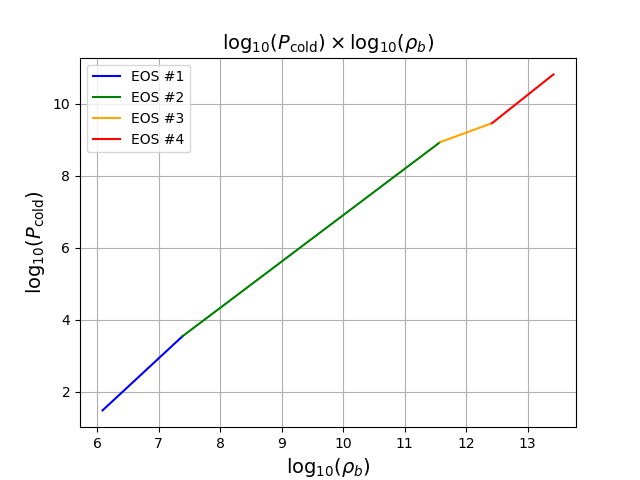

In [10]:
# Let us plot our piecewise polytropic so that we can see what is happening
# First set the number of points in the plot
n_plot = 1000

# Then split the plot by the number of EOSs used in the code
rho_b  = [0 for i in range(eos.neos)]
P_cold = [[0 for j in range(n_plot/eos.neos)] for i in range(eos.neos)]

# Then set the plotting limits for each region
lim = [eos.rho_poly_tab[0]/20.0,eos.rho_poly_tab[0],eos.rho_poly_tab[1],eos.rho_poly_tab[2],eos.rho_poly_tab[2]*10]

# Then populate the rho_b arrays
for j in range(eos.neos):
    rho_b[j] = np.linspace(lim[j],lim[j+1],n_plot/eos.neos)

# Finally, populate the P array
for i in range(eos.neos):
    for j in range(n_plot/4):
        P_cold[i][j] = Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_b[i][j])

import matplotlib.pyplot as plt
colors = ['blue','green','orange','red']
for i in range(eos.neos):
    plt.plot(np.log10(rho_b[i]),np.log10(P_cold[i]),label='EOS #'+str(i+1),c=colors[i])
plt.legend()
plt.title(r"$\log_{10}\left(P_{\rm cold}\right)\times\log_{10}\left(\rho_{b}\right)$",fontsize=14)
plt.xlabel(r"$\log_{10}\left(\rho_{b}\right)$",fontsize=14)
plt.ylabel(r"$\log_{10}\left(P_{\rm cold}\right)$",fontsize=14)
plt.grid()
plt.savefig("P_cold__rho_b__piecewise_polytrope.png")
plt.close()

from IPython.display import Image
Image("P_cold__rho_b__piecewise_polytrope.png")

<a id='tov'></a>

# Step 3: The TOV equations \[Back to [top](#toc)\]
$$\label{tov}$$

The [TOV line element](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) in terms of the *Schwarzschild coordinate* $r$ is written (in the $-+++$ form):
$$
ds^2 = - c^2 e^\nu dt^2 + \left(1 - \frac{2Gm}{rc^2}\right)^{-1} dr^2 + r^2 d\Omega^2,
$$
where $m(r)$ is the mass-energy enclosed at a given $r$, and is equal to the total star's mass outside the stellar radius $r=R$.

In terms of the *isotropic coordinate* $\bar{r}$ with $G=c=1$ (i.e., the coordinate system and units we'd prefer to use), the ($-+++$ form) line element is written:
$$
ds^2 = - e^{\nu} dt^2 + e^{4\phi} \left(d\bar{r}^2 + \bar{r}^2 d\Omega^2\right),
$$
where $\phi$ here is the *conformal factor*.

Setting components of the above line element equal to one another, we get (in $G=c=1$ units):

\begin{align}
r^2 &= e^{4\phi} \bar{r}^2 \implies e^{4\phi} = \frac{r^2}{\bar{r}^2} \\
\left(1 - \frac{2m}{r}\right)^{-1} dr^2 &= e^{4\phi} d\bar{r}^2 \\
\implies \frac{d\bar{r}(r)}{dr} &= \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}.
\end{align}

The TOV equations provide radial ODEs for the pressure and $\nu$ (from [the Wikipedia article on the TOV solution](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation)):

\begin{align}
\frac{dP}{dr} &= - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &= \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\end{align}

Assuming a polytropic equation of state, which relates the pressure $P$ to the baryonic rest-mass density $\rho_B$,

$$
P(\rho_B) = K \rho_B^\Gamma,
$$
the specific internal energy will be given by
$$
\epsilon = \frac{P}{\rho_B (\Gamma - 1)},
$$

so the total mass-energy density $\rho$ is given by
$$
\rho = \rho_B (1 + \epsilon).
$$

Given this, the mass-energy $m(r)$ density is the solution to the ODE:
$$
\frac{m(r)}{dr} = 4\pi r^2 \rho(r)
$$

Thus the full set of ODEs that need to be solved is given by

$$
\boxed{
\begin{align}
\frac{dP}{dr} &= - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &= \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\frac{m(r)}{dr} &= 4\pi r^2 \rho(r) \\
\frac{d\bar{r}(r)}{dr} &= \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}
\end{align}
}\ .
$$

The following code solves these equations, and was largely written by Phil Chang.

In [11]:
# Step 2: The TOV equations

## TOV SOLVER FOR SINGLE AND PIECEWISE POLYTROPES
## Authors: Phil Chang, Zachariah B. Etienne, Leo Werneck

# Full documentation for this module may be found in the NRPy+ tutorial Jupyter notebook:
#  Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb

# Inputs:
# * Output data file name
# * rho_baryon_central, the central density of the TOV star.
# * n, the polytropic equation of state index. n=1 models cold, degenerate neutron star matter.
# * K_Polytrope, the polytropic constant.
# * Verbose output toggle (default = True)

# Output: An initial data file (default file name = "outputTOVpolytrope.txt") that well
#         samples the (spherically symmetric) solution both inside and outside the star.
#         It is up to the initial data module to perform the 1D interpolation to generate
#         the solution at arbitrary radius. The file has the following columns:
# Column 1: Schwarzschild radius
# Column 2: rho(r), *total* mass-energy density (as opposed to baryonic rest-mass density)
# Column 3: P(r), Pressure
# Column 4: m(r), mass enclosed
# Column 5: e^{nu(r)}, g_{tt}(r)
# Column 6: e^{4 phi(r)}, conformal factor g_{rr}(r)
# Column 7: rbar(r), Isotropic radius

# rbar refers to the isotropic radius, and
# R_Schw refers to the Schwarzschild radius

def TOV_rhs(r_Schw, y) : 
# In \tilde units
#
    P    = y[0]
    m    = y[1]
    nu   = y[2]
    rbar = y[3]
    
    j = polytropic_index_from_P(eos,P)
    Gamma = Gamma_poly_tab[j]
    Gam1  = Gamma-1.0
    
    rho_baryon = Polytrope_EOS__compute_rhob_from_P_cold(eos,P)
    rho = rho_baryon + P/Gam1 # rho is the *total* mass-energy density!
    
    if( r_Schw < 1e-4 or m <= 0.): 
        m = 4*math.pi/3. * rho*r_Schw**3
        dPdrSchw = -(rho + P)*(4.*math.pi/3.*r_Schw*rho + 4.*math.pi*r_Schw*P)/(1.-8.*math.pi*rho*r_Schw*r_Schw)
        drbardrSchw = 1./(1. - 8.*math.pi*rho*r_Schw*r_Schw)**0.5
    else:
        dPdrSchw = -(rho + P)*(m + 4.*math.pi*r_Schw**3*P)/(r_Schw*r_Schw*(1.-2.*m/r_Schw))
        drbardrSchw = 1./(1. - 2.*m/r_Schw)**0.5*rbar/r_Schw
    
    dmdrSchw  =  4.*math.pi*r_Schw*r_Schw*rho
    dnudrSchw = -2./(P + rho)*dPdrSchw
    return [dPdrSchw, dmdrSchw, dnudrSchw, drbardrSchw]

def integrateStar( eos, P, dumpData = False):
    integrator = si.ode(TOV_rhs).set_integrator('dop853')
    y0 = [P, 0., 0., 0.]
    integrator.set_initial_value(y0,0.)
    dr_Schw = 1e-5
    P = y0[0]

    PArr      = []
    r_SchwArr = []
    mArr      = []
    nuArr     = []
    rbarArr   = []

    r_Schw = 0.

    while integrator.successful() and P > 1e-9*y0[0] : 
        P, m, nu, rbar = integrator.integrate(r_Schw + dr_Schw)
        r_Schw = integrator.t

        dPdrSchw, dmdrSchw, dnudrSchw, drbardrSchw = TOV_rhs( r_Schw+dr_Schw, [P,m,nu,rbar])
        dr_Schw = 0.1*min(abs(P/dPdrSchw), abs(m/dmdrSchw))
        dr_Schw = min(dr_Schw, 1e-2)
        PArr.append(P)
        r_SchwArr.append(r_Schw)
        mArr.append(m)
        nuArr.append(nu)
        rbarArr.append(rbar)

    M = mArr[-1]
    R_Schw = r_SchwArr[-1]

    # Apply integration constant to ensure rbar is continuous across TOV surface
    for ii in range(len(rbarArr)):
        rbarArr[ii] *= 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / rbarArr[-1]
    
    nuArr_np = np.array(nuArr)
    # Rescale solution to nu so that it satisfies BC: exp(nu(R))=exp(nutilde-nu(r=R)) * (1 - 2m(R)/R)
    #   Thus, nu(R) = (nutilde - nu(r=R)) + log(1 - 2*m(R)/R)
    nuArr_np = nuArr_np - nuArr_np[-1] + math.log(1.-2.*mArr[-1]/r_SchwArr[-1])

    r_SchwArrExtend_np = 10.**(np.arange(0.01,5.0,0.01))*r_SchwArr[-1]
    
    r_SchwArr.extend(r_SchwArrExtend_np)
    mArr.extend(r_SchwArrExtend_np*0. + M)
    PArr.extend(r_SchwArrExtend_np*0.)
    exp2phiArr_np = np.append( np.exp(nuArr_np), 1. - 2.*M/r_SchwArrExtend_np)
    nuArr.extend(np.log(1. - 2.*M/r_SchwArrExtend_np))
    rbarArr.extend( 0.5*(np.sqrt(r_SchwArrExtend_np**2 - 2.*M*r_SchwArrExtend_np) + r_SchwArrExtend_np - M) )

    # Appending to a Python array does what one would reasonably expect.
    #   Appending to a numpy array allocates space for a new array with size+1,
    #   then copies the data over... over and over... super inefficient.
    r_SchwArr_np     = np.array(r_SchwArr)
    PArr_np          = np.array(PArr)
    rho_baryonArr_np = np.array(PArr)
    for j in range(len(PArr_np)):
        # Compute rho_b from P
        rho_baryonArr_np[j] = Polytrope_EOS__compute_rhob_from_P_cold(eos,PArr_np[j])
        
    mArr_np               = np.array(mArr)
    rbarArr_np            = np.array(rbarArr)
    confFactor_exp4phi_np = (r_SchwArr_np/rbarArr_np)**2

    # Compute the *total* mass-energy density (as opposed to the *baryonic* mass density)
    rhoArr_np = []
    for i in range(len(rho_baryonArr_np)):
        polytropic_index = 0
        if not (eos.neos==1):
            for i in range(eos.neos-1):
                polytropic_index += (PArr_np[j] > P_poly_tab[i])
        
        rhoArr_np.append(rho_baryonArr_np[i] + PArr_np[i]/(eos.Gamma_poly_tab[polytropic_index] - 1.))
    
    print(len(r_SchwArr_np),len(rhoArr_np),len(PArr_np),len(mArr_np),len(exp2phiArr_np))
    # Special thanks to Leonardo Werneck for pointing out this issue with zip()
    if sys.version_info[0] < 3:
        np.savetxt("outputTOVpolytrope.txt", zip(r_SchwArr_np,rhoArr_np,PArr_np,mArr_np,exp2phiArr_np,confFactor_exp4phi_np,rbarArr_np), 
                   fmt="%.15e")
    else:
        np.savetxt("outputTOVpolytrope.txt", list(zip(r_SchwArr_np,rhoArr_np,PArr_np,mArr_np,exp2phiArr_np,confFactor_exp4phi_np,rbarArr_np)), 
                   fmt="%.15e")

    return R_Schw, M

############################
# Single polytrope example #
############################
# Set neos = 1 (single polytrope)
neos = 1

# Set rho_poly_tab (not needed for a single polytrope)
rho_poly_tab = []

# Set Gamma_poly_tab
Gamma_poly_tab = [2.0]

# Set K_poly_tab0
K_poly_tab0 = 1. # ZACH NOTES: CHANGED FROM 100.

# Set the eos quantities
eos = set_single_or_piecewise_polytrope_EOS_parameters(neos,rho_poly_tab,Gamma_poly_tab,K_poly_tab0)

# Set initial condition (Pressure computed from central density)
rho_baryon_central  = 0.129285
P_initial_condition = Polytrope_EOS__compute_P_cold_from_rhob(eos, rho_baryon_central)

R_Schw_TOV,M_TOV = integrateStar(eos, P_initial_condition, True)
print("Just generated a TOV star with R_Schw = "+str(R_Schw_TOV)+" , M = "+str(M_TOV)+" , M/R_Schw = "+str(M_TOV/R_Schw_TOV)+" .")

(1051, 1051, 1051, 1051, 1051)
Just generated a TOV star with R_Schw = 0.956568142523 , M = 0.14050303285288188 , M/R_Schw = 0.1468824086931645 .


<a id='code_validation'></a>

# Step 4: Code Validation against `TOV.TOV_Solver` NRPy+ module \[Back to [top](#toc)\]
$$\label{code_validation}$$

Here, as a code validation check, we verify agreement in the SymPy expressions for these TOV initial data between

1. this tutorial and 
2. the NRPy+ [TOV.TOV_Solver](../edit/TOV/TOV_Solver.py) module.

In [12]:
# Step 3: Code Validation against TOV.TOV_Solver module

import filecmp

import TOV.TOV_Solver as TOV
TOV.TOV_Solver("outputTOVpolytrope-validation.txt",rho_baryon_central=0.129285, n_Polytrope=1.0, K_Polytrope=1.0,
               verbose = False)

if filecmp.cmp('outputTOVpolytrope.txt',
               'outputTOVpolytrope-validation.txt') == False:
    print("ERROR: TOV initial data test FAILED!")
    exit(1)
else:
    print("TOV initial data test PASSED.")

TOV initial data test PASSED.


<a id='latex_pdf_output'></a>

# Step 5: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ADM_Initial_Data-TOV](Tutorial-ADM_Initial_Data-TOV.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-ADM_Initial_Data-TOV.ipynb
!pdflatex -interaction=batchmode Tutorial-ADM_Initial_Data-TOV.tex
!pdflatex -interaction=batchmode Tutorial-ADM_Initial_Data-TOV.tex
!pdflatex -interaction=batchmode Tutorial-ADM_Initial_Data-TOV.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-ADM_Initial_Data-TOV.ipynb to latex
[NbConvertApp] Support files will be in Tutorial-ADM_Initial_Data-TOV_files/
[NbConvertApp] Making directory Tutorial-ADM_Initial_Data-TOV_files
[NbConvertApp] Writing 97072 bytes to Tutorial-ADM_Initial_Data-TOV.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
